## Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats

## Function definitions

### Function to create dataframe with date, maintenance and production numbers per location

In [2]:
def daily_prod_data_load(loc):
    p_daily_prod_data_folder = os.path.join("..", "data", "input", "daily_production", f"{loc}")
    files = os.listdir(p_daily_prod_data_folder)
    rows_daily_prod_data = list()
    row_index = list()
    for file in files:
        p_daily_prod_data_file = os.path.join("..", "data", "input", "daily_production", f"{loc}", f"{file}")
        file_name = file.split(".")[0]
        date = datetime.strptime(file_name, '%Y%m%d').date()
        row_index.append(date)
        with open(p_daily_prod_data_file, 'r') as f_daily_prod_data:
            daily_prod_data_dict = json.load(f_daily_prod_data)
            # Set production value to zero for maintenance days
            if daily_prod_data_dict["production"] == "#MV":
                daily_prod_data_dict["production"] = 0
            daily_prod_data_series = pd.Series(daily_prod_data_dict)[["maintenance", "production"]]
        rows_daily_prod_data.append(daily_prod_data_series)
    df = pd.DataFrame(rows_daily_prod_data, index = row_index)

    df = add_maintenance_info(df)
    
    return df

### Function to add two columns (days since last maintenance & days until next maintenance) to dataframe

In [3]:
def add_maintenance_info(df):
    prev_day = df["maintenance"].iloc[0] # to keep track whether or not the previous day had maintenance
    start_maintenance_days = list() # all dates on which maintenance started
    end_maintenance_days = list() # all dates on which maintenance ended
    for date, maintenance_day in df["maintenance"].items():
        if maintenance_day == "Yes" and prev_day == "No":
            start_maintenance_days.append(date)
        elif maintenance_day == "No" and prev_day == "Yes":
            end_maintenance_days.append(date - timedelta(days=1))
        prev_day = maintenance_day
        
    start_maintenance_days.append(date.min)
    end_maintenance_days.insert(0, date.max)

    maintenance_occurence = 0 # loop through all different occurences maintenance took place
    in_maintenance = False
    next_maintenance_start = start_maintenance_days[maintenance_occurence]
    last_maintenance_end = end_maintenance_days[maintenance_occurence]
    days_until_next_maintenance_start_list = list()
    days_since_last_maintenance_end_list = list()

    for date in df.index:
        
        days_until_next_maintenance_start = np.nan
        days_since_last_maintenance_end = np.nan 
        
        if date < next_maintenance_start and not in_maintenance: # before maintenance
            days_until_next_maintenance_start = (next_maintenance_start - date).days
        if date == next_maintenance_start: # on day of start of maintenance
            in_maintenance = True
            maintenance_occurence += 1
            next_maintenance_start = start_maintenance_days[maintenance_occurence]
            last_maintenance_end = end_maintenance_days[maintenance_occurence]
        if date > last_maintenance_end and not in_maintenance: # after maintenance
            days_since_last_maintenance_end = (date - last_maintenance_end).days
        if date == last_maintenance_end: # on day of end of maintenance
            in_maintenance = False
        days_until_next_maintenance_start_list.append(days_until_next_maintenance_start)
        days_since_last_maintenance_end_list.append(days_since_last_maintenance_end)

    df["days_until_next_maintenance"] = days_until_next_maintenance_start_list
    df["days_since_last_maintenance"] = days_since_last_maintenance_end_list

    return df

### Function to calculate and plot the average production for each an x-day interval

In [50]:
def calc_average_prod_for_interval(days_until_or_since_maintenance_vs_production, interval_size):
    # Calculate the average production for each x-day interval
    num_intervals = len(days_until_or_since_maintenance_vs_production) // interval_size
    average_production_intervals = dict()
    
    for i in range(num_intervals):
        start_day = i * interval_size + 1
        end_day = (i + 1) * interval_size
        interval_values = list(days_until_or_since_maintenance_vs_production.values())[start_day - 1:end_day]
        average_production = sum(interval_values) / len(interval_values)
        average_production_intervals[end_day] = average_production

    return average_production_intervals

### Function to analyse the impact of an upcoming maintenance period on production numbers

In [82]:
def fun_days_until_maintenance_vs_production(df, interval_size):

    days_until_maintenance_vs_production = dict()
    
    for date, df_row in df.iterrows():
        if np.isnan(df_row["days_until_next_maintenance"]):
            continue
        elif int(df_row["days_until_next_maintenance"]) in days_until_maintenance_vs_production:
            days_until_maintenance_vs_production[int(df_row["days_until_next_maintenance"])].append(df_row["production"])
        else:
            days_until_maintenance_vs_production[int(df_row["days_until_next_maintenance"])] = [df_row["production"]]
    
    for days_until_maintenance, production in days_until_maintenance_vs_production.items():
        average_production = round(sum(production) / len(production))
        days_until_maintenance_vs_production[days_until_maintenance] = average_production
    days_until_maintenance_vs_production = dict(sorted(days_until_maintenance_vs_production.items()))

    average_production_intervals = dict()
    average_production_intervals = calc_average_prod_for_interval(days_until_maintenance_vs_production, interval_size)

    # Plot the average production for each x-day interval
    plt.bar(list(average_production_intervals.keys()), list(average_production_intervals.values()))
    plt.xlabel('Days until maintenance')
    plt.ylabel('Average Daily Production')
    plt.title(f'Average Daily Production in {interval_size}-day Intervals')
    plt.show()

### Function to analyse the impact of a recent maintenance period on production numbers

In [83]:
def fun_days_since_maintenance_vs_production(df, interval_size):

    days_since_maintenance_vs_production = dict()
    
    for date, df_row in df.iterrows():
        if np.isnan(df_row["days_since_last_maintenance"]):
            continue
        elif int(df_row["days_since_last_maintenance"]) in days_since_maintenance_vs_production:
            days_since_maintenance_vs_production[int(df_row["days_since_last_maintenance"])].append(df_row["production"])
        else:
            days_since_maintenance_vs_production[int(df_row["days_since_last_maintenance"])] = [df_row["production"]]
    
    for days_until_maintenance, production in days_since_maintenance_vs_production.items():
        average_production = round(sum(production) / len(production))
        days_since_maintenance_vs_production[days_until_maintenance] = average_production
    days_since_maintenance_vs_production = dict(sorted(days_since_maintenance_vs_production.items()))

    average_production_intervals = dict()
    average_production_intervals = calc_average_prod_for_interval(days_since_maintenance_vs_production, interval_size)

    # Plot the average production for each x-day interval
    plt.bar(list(average_production_intervals.keys()), list(average_production_intervals.values()))
    plt.xlabel('Days since maintenance')
    plt.ylabel('Average Daily Production')
    plt.title(f'Average Daily Production in {interval_size}-day Intervals')
    plt.show()

### Function to check how often each production amount reoccurs

In [120]:
def fun_number_of_days_with_x_production(df):
    number_of_days_with_x_production = dict() # how often does each production amount reoccur
    
    for production in df["production"]:
        if production in number_of_days_with_x_production:
            number_of_days_with_x_production[production] += 1
        else:
            number_of_days_with_x_production[production] = 1
    
    number_of_days_with_x_production = dict(sorted(number_of_days_with_x_production.items()))

    return number_of_days_with_x_production

### Function to find best distribution

In [176]:
def find_best_fit_distribution_continuous(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution (scipy.stats.rv_continuous): The best-fit distribution.
        best_params (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        distributions = [
            stats.norm,      # Normal distribution
            stats.gamma,     # Gamma distribution
            stats.expon,     # Exponential distribution
            stats.uniform    # Uniform distribution
        ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    for distribution in distributions:
        params = distribution.fit(data)
        sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params, best_sse

In [231]:
def find_best_fit_distribution_continuous_ext(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution (scipy.stats.rv_continuous): The best-fit distribution.
        best_params (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        distributions = [
            stats.norm,  # Normal Distribution
            stats.uniform,  # Uniform Distribution
            stats.expon,  # Exponential Distribution
            stats.chi2,  # Chi-Square Distribution
            stats.gamma,  # Gamma Distribution
            stats.lognorm,  # Log-Normal Distribution
            stats.beta,  # Beta Distribution
            stats.triang,  # Triangular Distribution
            stats.burr,  # Burr Distribution
            stats.cauchy,  # Cauchy Distribution
            stats.chi,  # Chi Distribution
            stats.f,  # F Distribution
            stats.foldcauchy,  # Folded Cauchy Distribution
            stats.foldnorm,  # Folded Normal Distribution
            stats.gumbel_r,  # Right-skewed Gumbel Distribution
            stats.gumbel_l,  # Left-skewed Gumbel Distribution
            stats.halfcauchy,  # Half Cauchy Distribution
            stats.halfnorm,  # Half Normal Distribution
            stats.invgamma,  # Inverse Gamma Distribution
            stats.invweibull,  # Inverse Weibull Distribution
            stats.johnsonsb,  # Johnson SB Distribution
            stats.johnsonsu,  # Johnson SU Distribution
            stats.kappa4,  # Kappa-4 Distribution
            stats.kappa3,  # Kappa-3 Distribution
            stats.ksone,  # Kolmogorov-Smirnov one-sided Distribution
            stats.kstwobign,  # Kolmogorov-Smirnov two-sided Distribution
            stats.levy,  # Levy Distribution
            stats.loglaplace,  # Log-Laplace Distribution
            stats.mielke,  # Mielke's Beta-Kappa Distribution
            stats.ncf,  # Non-central F Distribution
            stats.nct,  # Non-central Student's t Distribution
            #stats.norminvgauss,  # Inverse Gaussian Distribution
            stats.pareto,  # Pareto Distribution
            stats.powerlaw,  # Power-law Distribution
            stats.powerlognorm,  # Power-log Normal Distribution
            stats.powernorm,  # Power Normal Distribution
            stats.rayleigh,  # Rayleigh Distribution
            stats.rice,  # Rice Distribution
            stats.reciprocal,  # Reciprocal Distribution
            stats.semicircular,  # Semicircular Distribution
            stats.t,  # Student's t Distribution
            stats.trapz,  # Trapezoidal Distribution
            stats.triang,  # Triangular Distribution
            stats.tukeylambda,  # Tukey-Lambda Distribution
            #stats.vonmises,  # Von Mises Distribution
            stats.vonmises_line,  # Von Mises Line Distribution
            stats.wald,  # Wald (Inverse Gaussian) Distribution
            stats.weibull_min,  # Weibull Minimum Distribution
            stats.weibull_max,  # Weibull Maximum Distribution
            stats.wrapcauchy  # Wrapped Cauchy Distribution
        ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    for distribution in distributions:
        params = distribution.fit(data)
        sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params, best_sse

### Function to simulate a normal distribution many times

In [ ]:
def simulate_production(mean, std, zero_prob, n_days, num_simulations, lower_limit, upper_limit):
    total_production_results = []

    for _ in range(num_simulations):
        # Simulate production for each day
        daily_production = []

        for _ in range(n_days):
            # Generate a random number to decide whether to have zero production
            if np.random.rand() < zero_prob:
                daily_production.append(0)
            else:
                # Simulate production for non-zero production days using a normal distribution
                while True:
                    production_value = np.random.normal(mean, std)
                    # Check if the simulated value is within the specified range
                    if lower_limit <= production_value <= upper_limit:
                        break  # Exit the loop if the value is within the range

                daily_production.append(production_value)

        # Calculate the total production over the specified number of days
        total_production = np.sum(daily_production)
        
        # Store the total production result
        total_production_results.append(total_production)

    # Calculate the average total production over all simulations
    average_total_production = np.mean(total_production_results)
    
    return average_total_production

## Load master_data.json

In [5]:
p_master_data = os.path.join("..", "data", "input", "master_data.json")
with open(p_master_data, 'r') as f_master_data:
    master_data = json.load(f_master_data)

MSR_BRU = None
MSR_STO = None
for k, v in master_data.items():
    if "BRU" in k:
        MSR_BRU = v
    elif "STO" in k:
        MSR_STO = v
print(f"MSR_BRU: {MSR_BRU}")
print(f"MSR_STO: {MSR_STO}")

MSR_BRU: 1244
MSR_STO: 274


## Load daily production data

### for Brussels:

In [69]:
df_BRU = daily_prod_data_load("BRU")
print("BRU:")
display(df_BRU)

BRU:


,maintenance,production,days_until_next_maintenance,days_since_last_maintenance
2018-01-01,No,1183,116.0,NaN
2018-01-02,No,1138,115.0,NaN
2018-01-03,No,1115,114.0,NaN
2018-01-04,No,966,113.0,NaN
2018-01-05,No,1026,112.0,NaN
...,...,...,...,...
2022-12-31,No,1041,NaN,230.0
2023-01-01,No,1013,NaN,231.0
2023-01-02,No,1063,NaN,232.0
2023-01-03,No,1046,NaN,233.0


### for Stockholm:

In [70]:
df_STO = daily_prod_data_load("STO")
print("STO:")
display(df_STO)

STO:


,maintenance,production,days_until_next_maintenance,days_since_last_maintenance
2018-01-01,No,265,216.0,NaN
2018-01-02,No,265,215.0,NaN
2018-01-03,No,256,214.0,NaN
2018-01-04,No,252,213.0,NaN
2018-01-05,No,243,212.0,NaN
...,...,...,...,...
2022-12-31,No,223,NaN,125.0
2023-01-01,No,221,NaN,126.0
2023-01-02,No,213,NaN,127.0
2023-01-03,No,204,NaN,128.0


## Zoom on period around maintenance period

In [71]:
# to zoom in on the data before, during and after a maintenance period
start_date = datetime.strptime('20180422', '%Y%m%d').date()
end_date = datetime.strptime('20180519', '%Y%m%d').date()
print("BRU: maintenance 2018:")
display(df_BRU.loc[start_date:end_date])

start_date = datetime.strptime('20190315', '%Y%m%d').date()
end_date = datetime.strptime('20190501', '%Y%m%d').date()
print("\nBRU: maintenance 2019:")
display(df_BRU.loc[start_date:end_date])

BRU: maintenance 2018:


,maintenance,production,days_until_next_maintenance,days_since_last_maintenance
2018-04-22,No,1011,5.0,NaN
2018-04-23,No,946,4.0,NaN
2018-04-24,No,992,3.0,NaN
2018-04-25,No,0,2.0,NaN
2018-04-26,No,0,1.0,NaN
2018-04-27,Yes,0,NaN,NaN
2018-04-28,Yes,0,NaN,NaN
2018-04-29,Yes,0,NaN,NaN
2018-04-30,Yes,0,NaN,NaN
2018-05-01,Yes,0,NaN,NaN



BRU: maintenance 2019:


,maintenance,production,days_until_next_maintenance,days_since_last_maintenance
2019-03-15,No,882,4.0,304.0
2019-03-16,No,815,3.0,305.0
2019-03-17,No,863,2.0,306.0
2019-03-18,No,872,1.0,307.0
2019-03-19,Yes,0,NaN,NaN
2019-03-20,Yes,0,NaN,NaN
2019-03-21,Yes,0,NaN,NaN
2019-03-22,Yes,0,NaN,NaN
2019-03-23,Yes,0,NaN,NaN
2019-03-24,Yes,0,NaN,NaN


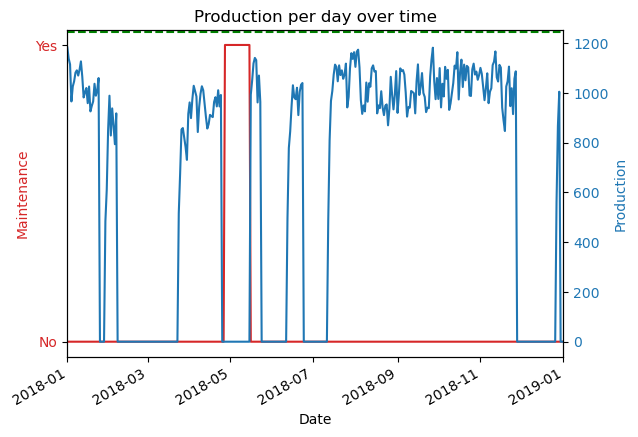

In [72]:
fig, ax_maintenance = plt.subplots()

# Plot the maintenance column in red with its own y-scale
ax_maintenance.set_xlabel('Date')
ax_maintenance.set_ylabel('Maintenance', color='tab:red')
ax_maintenance.plot(df_BRU.index, df_BRU.maintenance, color='tab:red')
ax_maintenance.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis sharing the same x-axis
ax_production = ax_maintenance.twinx()

# Plot the production column in blue with its own y-scale
ax_production.set_ylabel('Production', color='tab:blue')
ax_production.plot(df_BRU.index, df_BRU.production, color='tab:blue')
ax_production.tick_params(axis='y', labelcolor='tab:blue')

# Plot a horizontal line for the Maximal Sustainable Production Rate in green
ax_production.axhline(y=MSR_BRU, color='green', linestyle='--', label='Production Line')

plt.title('Production per day over time')
start_date = datetime.strptime('20180101', '%Y%m%d').date()
end_date = datetime.strptime('20190101', '%Y%m%d').date()
plt.xlim(start_date, end_date)
plt.xticks(rotation=45, ha="right")
fig.autofmt_xdate()
plt.show()

## Analysis of impact of upcoming maintenance period on production numbers

### For Brussels:

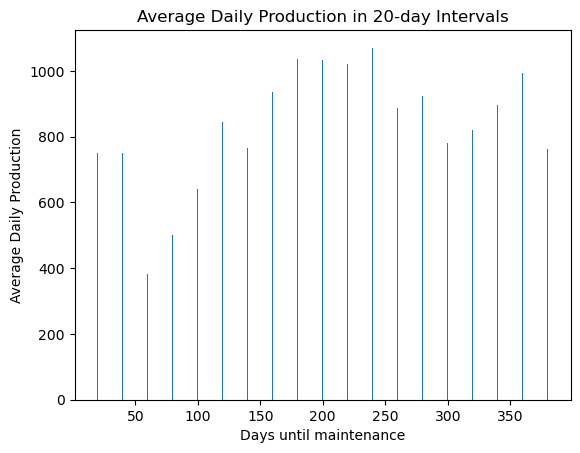

In [84]:
fun_days_until_maintenance_vs_production(df_BRU, 20)

### For Stockholm:

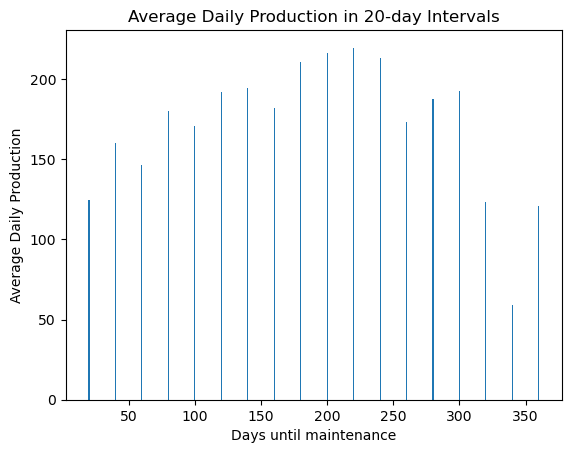

In [85]:
fun_days_until_maintenance_vs_production(df_STO, 20)

Conclusion: the production numbers at the start of the trend (so right before the upcoming maintenance period) are not marginal enough to ignore them in the simulation

## Analysis of impact of recent maintenance period on production numbers

### For Brussels:

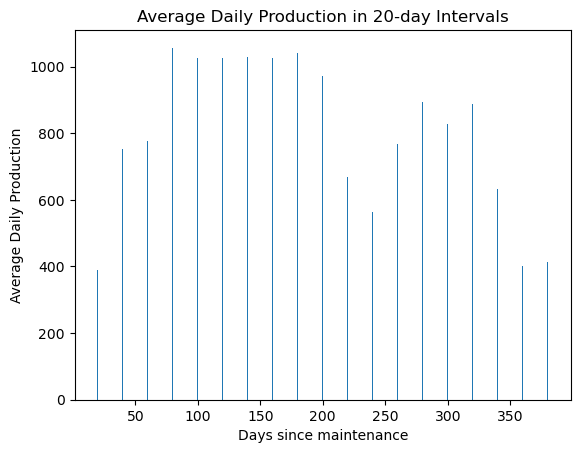

In [86]:
fun_days_since_maintenance_vs_production(df_BRU, 20)

### For Stockholm:

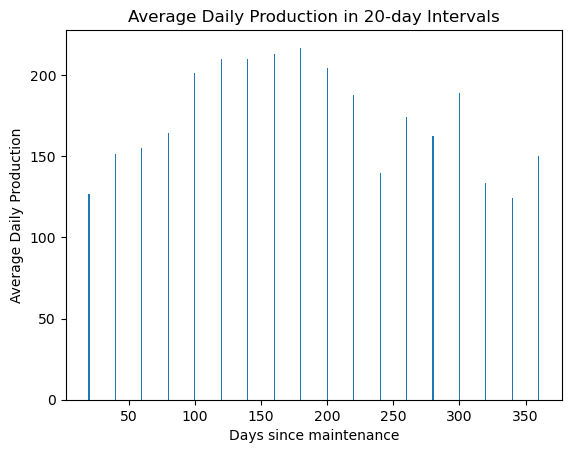

In [87]:
fun_days_since_maintenance_vs_production(df_STO, 20)

Conclusion: the production numbers at the start of the trend (so right after the previous maintenance period) are not marginal enough to ignore them in the simulation

## Check how often each production amount reoccurs

In [135]:
print("For Brussels:")
print(fun_number_of_days_with_x_production(df_BRU))

print("\nFor Stockholm:")
print(fun_number_of_days_with_x_production(df_STO))

For Brussels:
{0: 402, 348: 1, 418: 1, 454: 1, 466: 1, 474: 1, 475: 1, 481: 1, 483: 1, 484: 1, 486: 1, 488: 1, 492: 1, 496: 2, 516: 1, 556: 1, 560: 1, 562: 1, 567: 1, 582: 1, 611: 1, 630: 1, 642: 1, 644: 1, 658: 1, 676: 1, 684: 1, 700: 1, 703: 1, 704: 1, 710: 1, 726: 1, 728: 1, 731: 1, 733: 1, 738: 1, 743: 1, 750: 1, 762: 1, 766: 1, 777: 1, 778: 2, 779: 3, 780: 1, 783: 1, 789: 2, 791: 2, 792: 2, 794: 2, 797: 1, 798: 2, 800: 1, 801: 1, 805: 3, 809: 2, 810: 1, 812: 1, 815: 1, 820: 2, 821: 2, 823: 2, 824: 2, 825: 3, 826: 1, 827: 2, 829: 1, 831: 2, 832: 2, 834: 1, 837: 1, 838: 1, 840: 1, 841: 1, 843: 2, 844: 1, 846: 2, 847: 3, 848: 3, 850: 2, 851: 1, 853: 2, 855: 2, 856: 1, 857: 4, 858: 5, 859: 3, 860: 2, 861: 1, 863: 2, 864: 2, 866: 2, 867: 5, 868: 1, 869: 1, 870: 2, 871: 4, 872: 3, 874: 1, 875: 5, 876: 1, 878: 1, 879: 3, 880: 1, 881: 1, 882: 4, 883: 1, 884: 2, 885: 5, 886: 1, 887: 3, 888: 2, 889: 3, 890: 3, 891: 1, 892: 2, 893: 2, 894: 2, 895: 5, 896: 1, 897: 5, 898: 5, 899: 2, 900: 3, 9

## Creating data sets without maintenance and without zero and calculate chance of having an unplanned zero day

In [111]:
# delete all maintenance days from Brussels data set
df_BRU_without_maintenance_days = df_BRU[df_BRU["maintenance"] == "No"]
print(f'Number of days in Brussels data set leaving out the maintenance days: {len(df_BRU_without_maintenance_days)}')

# delete all zero production days from Brussels data set
df_BRU_without_zero_days = df_BRU[df_BRU["production"] != 0]
print(f'Number of days in Brussels data set leaving out the zero days: {len(df_BRU_without_zero_days)}')

# calculate the chance of having an unplanned zero day in Brussels
BRU_unplanned_zero_day = (len(df_BRU_without_maintenance_days) - len(df_BRU_without_zero_days)) / len(df_BRU_without_maintenance_days)
print(f'Chance of having an unplanned zero day in Brussels: {BRU_unplanned_zero_day}')

print("")

# delete all maintenance days from Stockholm data set
df_STO_without_maintenance_days = df_STO[df_STO["maintenance"] == "No"]
print(f'Number of days in Stockholm data set leaving out the maintenance days: {len(df_STO_without_maintenance_days)}')

# delete all zero production days from Stockholm data set
df_STO_without_zero_days = df_STO[df_STO["production"] != 0]
print(f'Number of days in Stockholm data set leaving out the zero days: {len(df_STO_without_zero_days)}')

# calculate the chance of having an unplanned zero day in Stockholm
STO_unplanned_zero_day = (len(df_STO_without_maintenance_days) - len(df_STO_without_zero_days)) / len(df_STO_without_maintenance_days)
print(f'Chance of having an unplanned zero day in Stockholm: {STO_unplanned_zero_day}')

Number of days in Brussels data set leaving out the maintenance days: 1736
Number of days in Brussels data set leaving out the zero days: 1428
Chance of having an unplanned zero day in Brussels: 0.1774193548387097

Number of days in Stockholm data set leaving out the maintenance days: 1716
Number of days in Stockholm data set leaving out the zero days: 1590
Chance of having an unplanned zero day in Stockholm: 0.07342657342657342


## Best distributions

### For Brussels:

In [237]:
BRU_best_distribution, BRU_best_params, BRU_best_sse = find_best_fit_distribution_continuous(df_BRU_without_zero_days.production)
print("For Brussels:")
print(f"Best-fit distribution: {BRU_best_distribution.name}")
print(f"Parameters: {BRU_best_params}")
print(f"SSE: {BRU_best_sse}")

For Brussels:
Best-fit distribution: norm
Parameters: (989.218487394958, 108.90790262811456)
SSE: 1414303522.896852


In [238]:
BRU_mean = BRU_best_params[0]
BRU_std = BRU_best_params[1]

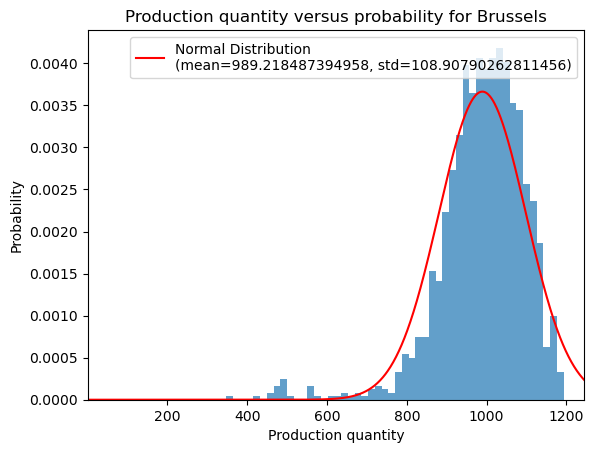

In [239]:
plt.hist(df_BRU_without_zero_days.production, density=True, alpha=0.7, bins=50)
plt.xlim(1, MSR_BRU)

mean = BRU_mean
std = BRU_std
x = np.linspace(1, MSR_BRU, MSR_BRU)
pdf = stats.norm.pdf(x, mean, std)

plt.plot(x, pdf, label=f'Normal Distribution\n(mean={mean}, std={std})', color="red")
plt.xlabel("Production quantity")
plt.ylabel("Probability")
plt.title("Production quantity versus probability for Brussels")
plt.legend()
plt.show()

### For Stockholm:

In [234]:
STO_best_distribution, STO_best_params, STO_best_sse = find_best_fit_distribution_continuous(df_STO_without_zero_days.production)
print("For Stockholm:")
print(f"Best-fit distribution: {STO_best_distribution.name}")
print(f"Parameters: {STO_best_params}")
print(f"SSE: {STO_best_sse}")

For Stockholm:
Best-fit distribution: norm
Parameters: (190.9679245283019, 40.17786996986101)
SSE: 60546808.11258799


In [235]:
STO_mean = STO_best_params[0]
STO_std = STO_best_params[1]

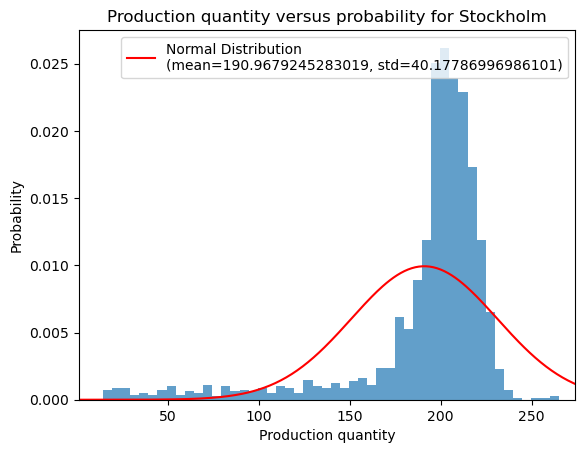

In [236]:
plt.hist(df_STO_without_zero_days.production, density=True, alpha=0.7, bins=50)
plt.xlim(1, MSR_STO)

mean = STO_mean
std = STO_std
x = np.linspace(1, MSR_STO, MSR_STO)
pdf = stats.norm.pdf(x, mean, std)

plt.plot(x, pdf, label=f'Normal Distribution\n(mean={mean}, std={std})', color="red")
plt.xlabel("Production quantity")
plt.ylabel("Probability")
plt.title("Production quantity versus probability for Stockholm")
plt.legend()
plt.show()

## Simulation

### For Brussels:

In [240]:
mean_production = BRU_mean  # Replace with your desired mean
std_production = BRU_std   # Replace with your desired standard deviation
zero_prob = BRU_unplanned_zero_day # Replace with the probability of having a zero production day
simulation_days = 5   # Replace with the number of days you want to simulate
num_simulations = 10**6  # Replace with the desired number of simulations
lower_limit = 1  # Replace with the lower production limit
upper_limit = MSR_BRU  # Replace with the upper production limit

average_total_production_result = simulate_production(mean_production, std_production, zero_prob, simulation_days, num_simulations, lower_limit, upper_limit)

print(f"For Brussels the average total production over {simulation_days} days, averaged over {num_simulations} simulations: {average_total_production_result}")

For Brussels the average total production over 5 days, averaged over 1000000 simulations: 4055.928560091837


### For Stockholm:

In [241]:
mean_production = STO_mean  # Replace with your desired mean
std_production = STO_std   # Replace with your desired standard deviation
zero_prob = STO_unplanned_zero_day # Replace with the probability of having a zero production day
simulation_days = 5   # Replace with the number of days you want to simulate
num_simulations = 10**6  # Replace with the desired number of simulations
lower_limit = 1  # Replace with the lower production limit
upper_limit = MSR_STO  # Replace with the upper production limit

average_total_production_result = simulate_production(mean_production, std_production, zero_prob, simulation_days, num_simulations, lower_limit, upper_limit)

print(f"For Stockholm the average total production over {simulation_days} days, averaged over {num_simulations} simulations: {average_total_production_result}")

For Stockholm the average total production over 5 days, averaged over 1000000 simulations: 875.8748540310652


to do: 
- Step 7: Use your simulation